## Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Analyzing, cleaning, exploring data
import pandas as pd
from pandas import DataFrame
import re
import glob

# Performing math operations on arrays and other structures.
import numpy as np

# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import pywt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from keras.models import load_model


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



## Import and Process Data

In the cell below we import 700 files, assign columns, extract names and numbers from the file names and build a combined dataframe.

In [ ]:
# Initialize Lists
truncated_data = []
new_list2 = []
dataframes = []
total_num_rows = 0
extracted_strings = []
gesture_list = []

# Specify the folder path where the CSV files are located
folder_path = "/content/drive/MyDrive/EMGforMSc_lateral/"

# Column Names
columns = ['Timestamp', 'El1', 'El2', 'El3','El4', 'El5', 'El6','El7', 'El8']


# Get a list of all CSV files in the folder
file_list = glob.glob(folder_path + "*.csv")

for file in file_list:
    df = pd.read_csv(file, names=columns)

    # Truncate the DataFrames to 100 rows
    truncated_df = df[:150]

    # Add the truncated DataFrame to the list
    truncated_data.append(truncated_df)
    #num_rows = 200

    file_name = file.split("/")[-1]  # Extract the file name from the file path
    gesture = re.search(r'-(.*?)-', file_name).group(1)  # Extract the desired string using regex

    # Get a list for the target variable
    gesture_list.extend([gesture])

    # Get a list in case we need to add a column to the df
    #extracted_strings.extend([gesture] * num_rows)

    # Get the Patient ID
    extracted_numbers = re.findall(r'\d+', file)[0]


    #new_list = [extracted_numbers] * num_rows
    #new_list2.append(new_list)
    #dataframes.append(df)

    #total_num_rows += num_rows
    #filtered_dataframes = [truncated_data for truncated_data in dataframes if len(truncated_data) <= 200]




combined_df = pd.concat(truncated_data, ignore_index=False) # The final df with all the data
#new_list2 = [item for sublist in new_list2 for item in sublist]  # Flatten the nested list


In [ ]:
combined_df

,Timestamp,El1,El2,El3,El4,El5,El6,El7,El8
0,1644424821135,240,196,257,774,585,181,98,145
1,1644424821274,253,195,256,804,540,157,92,158
2,1644424821410,254,193,240,756,477,117,69,177
3,1644424821537,268,239,275,762,487,119,73,186
4,1644424821797,255,202,259,742,432,119,76,270
...,...,...,...,...,...,...,...,...,...
145,1643730615430,21,16,23,22,56,104,115,28
146,1643730615436,22,18,24,26,64,105,121,30
147,1643730615442,20,19,22,25,54,103,121,27
148,1643730615448,20,19,25,25,52,97,121,26


In [ ]:
labels = ['open', 'close',  'tripod','grasp','neutral']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the encoded labels and their corresponding original labels
label_mapping = dict(zip(encoded_labels, labels))
for encoded_label, original_label in label_mapping.items():
    print(f"Encoded Label: {encoded_label} - Original Label: {original_label}")

Encoded Label: 3 - Original Label: open
Encoded Label: 0 - Original Label: close
Encoded Label: 4 - Original Label: tripod
Encoded Label: 1 - Original Label: grasp
Encoded Label: 2 - Original Label: neutral


## Encode the Target Variable

Seems to be necessary for a CNN. Encoded all gestures below.

In [ ]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable as integer labels
integer_labels = label_encoder.fit_transform(gesture_list)

# Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape the integer labels to a 2D array
integer_labels = integer_labels.reshape(-1, 1)

# One-hot encode the integer labels
onehot_encoded = onehot_encoder.fit_transform(integer_labels)

onehot_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
# Convert to Array
gesture_list = np.array(onehot_encoded)


In [ ]:
# Copy dataframe for good measure
df = combined_df.copy()

## Apply Continuous Wavelet Transform

In [ ]:
# Define parameters
scales = np.arange(1, 151)
waveletname = "morl"
num_rows = 150
num_columns = 8


# Extract the electrode readings columns
data = df.iloc[:, 1:].values  # Exclude the timestamp column

# Reshape the data into 3D array (number of samples, number of rows, number of columns)
data = data.reshape(-1, num_rows, num_columns)

# Apply continuous wavelet transform to each sample
transformed_data = []

for sample in data:
    transformed_sample = []
    for channel in sample.T:  # Transpose to loop over columns (channels)
        coeff, _ = pywt.cwt(channel, scales, waveletname, 1)
        transformed_sample.append(coeff)
    transformed_data.append(np.array(transformed_sample))

# Convert the transformed data into a numpy array
transformed_data = np.array(transformed_data)

In [ ]:
transformed_data.shape

(589, 8, 150, 150)

In [ ]:
# Reshape data to the format below
reshaped_data = transformed_data.transpose((0, 3, 2, 1))


In [ ]:
# 700 files/signals
# 100 rows from each file
# 100 coefficients of each row
# 8 channels representing the electrode readings

reshaped_data.shape

(589, 150, 150, 8)

## Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, gesture_list, test_size=0.2, random_state=42)


## A Rudimentary CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


# Build the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 8)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
#opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summarize Model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 36, 36, 32)       

In [ ]:
# Fit the Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = '/content/drive/MyDrive/Biosginal_models/best_model.h5'


checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')

model.fit(X_train, y_train, batch_size=16, epochs=50,callbacks=[checkpoint], validation_data=(X_test, y_test))
#model.fit(X_train, y_train, batch_size=16, epochs=20,callbacks=[checkpoint], validation_data=(X_test, y_test))

Epoch 1/50
30/30 [==============================] - 24s 733ms/step - loss: 78.9112 - categorical_accuracy: 0.2930 - val_loss: 1.5038 - val_categorical_accuracy: 0.3305
Epoch 2/50
30/30 [==============================] - 16s 546ms/step - loss: 1.3063 - categorical_accuracy: 0.4883 - val_loss: 1.2445 - val_categorical_accuracy: 0.5678
Epoch 3/50
30/30 [==============================] - 15s 513ms/step - loss: 0.9748 - categorical_accuracy: 0.6263 - val_loss: 1.6005 - val_categorical_accuracy: 0.4492
Epoch 4/50
30/30 [==============================] - 16s 549ms/step - loss: 0.9072 - categorical_accuracy: 0.6985 - val_loss: 1.1797 - val_categorical_accuracy: 0.7203
Epoch 5/50
30/30 [==============================] - 16s 541ms/step - loss: 0.8753 - categorical_accuracy: 0.6688 - val_loss: 0.8494 - val_categorical_accuracy: 0.7627
Epoch 6/50
30/30 [==============================] - 16s 539ms/step - loss: 0.9129 - categorical_accuracy: 0.7325 - val_loss: 1.3165 - val_categorical_accuracy: 0.61

In [ ]:

best_model = load_model(checkpoint_filepath)


In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = best_model.evaluate(X_test, y_test)

# Print the validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

4/4 [==============================] - 1s 173ms/step - loss: 0.9171 - categorical_accuracy: 0.8644
Validation Loss: 0.9171446561813354
Validation Accuracy: 0.8644067645072937


4/4 [==============================] - 1s 227ms/step


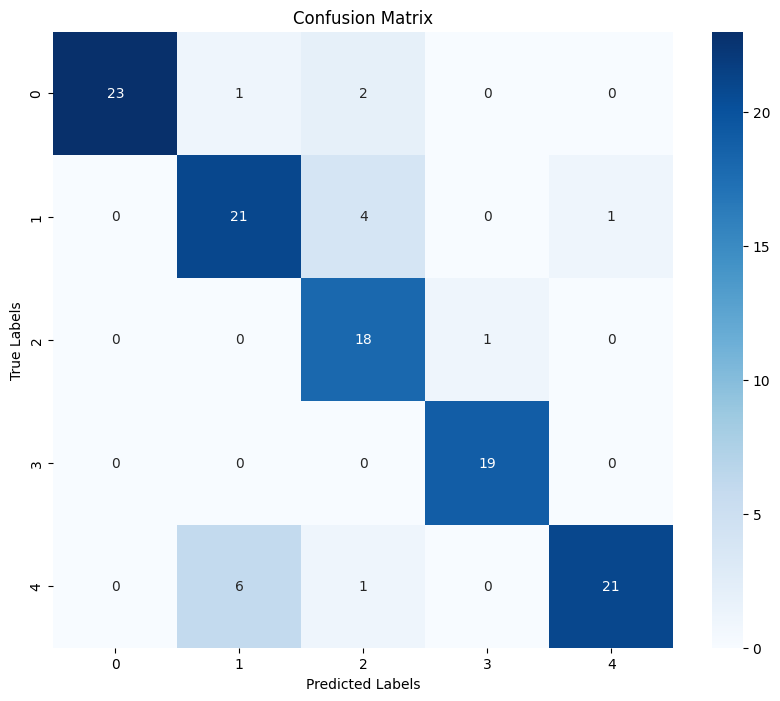

In [ ]:
y_pred_probs = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels)
accuracy

0.864406779661017